In [6]:
from datetime import datetime, timedelta
from dateutil import parser
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
import warnings
import math

sns.set()
sns.set_style('whitegrid')
warnings.filterwarnings("ignore") 

charging_speed = 10
charging_fee = 0.3  
parking_slots_num = 10
ALPHA = 0.5

building_start_time = parser.parse("2018-07-01")
building_end_time = parser.parse("2018-07-08")
charging_start_time = parser.parse("2018-07-01")
charging_end_time = parser.parse("2018-07-08")

location = pd.read_csv("./Dataset/location_5.csv", index_col="locationId")
location.index = location.index.astype(str) # 將索引轉換為字串型態
location = location.sort_values(by="buildingID") # 以 "buildingID" 這個欄位為鍵進行排序。
location["buildingID"] = location["buildingID"].astype(str) # 將 "buildingID" 這個欄位轉換為字串型態。

location.loc["50911", "contractCapacity"] = 222 #13
location.loc["50266", "contractCapacity"] = 273 #10

building_data = pd.read_csv("./Dataset/generation_with_consumption_3.csv", index_col=0)
building_LSTM_data = pd.read_csv("./Result/predict_building_data.csv", index_col=0)
charging_data = pd.read_csv("./Dataset/charging_data_2_move.csv")

building_data["datetime"] = pd.to_datetime(building_data["datetime"], format="%Y-%m-%d %H:%M:%S")
building_data["buildingID"] = building_data["buildingID"].astype(str)

building_LSTM_data["datetime"] = pd.to_datetime(building_LSTM_data["datetime"], format="%Y-%m-%d %H:%M:%S")
building_LSTM_data["buildingID"] = building_LSTM_data["buildingID"].astype(str)

charging_data["createdNew"] = pd.to_datetime(charging_data["createdNew"], format="%Y-%m-%d %H:%M:%S")
charging_data["locationId"] = charging_data["locationId"].astype(str)
charging_data["userId"] = charging_data["userId"].astype(str)

building_data.loc[building_data["buildingID"] == "13", "contract_capacity"] = 222
building_data.loc[building_data["buildingID"] == "10", "contract_capacity"] = 273

In [7]:
def calculate_electricity_price(location, locationID, info):
    import time
    # print(info)
    testing_start_time = charging_start_time
    each_building_price = 262.5 / 30.73
    # capacity_price = 236.2
    capacity_price = 15.51 # 236.2 NT$ 236.2 --> US$ 15.51 Kw/month
    contract_capacity = location.loc[locationID, "contractCapacity"]
    electricity_price = defaultdict()

    # 0.056 舉例為 $0.056/kWh
    for weekday in range(1, 8):
        if weekday < 6:
            electricity_price[weekday] = [0.056] * 8 + [0.092] * 4 + [0.267] * 6 + [0.092] * 5 + [0.056] * 1
        else:
            electricity_price[weekday] = [0.056] * 24
    
    ### 基本電費 ### 
    # 每戶每月電價: each_building_price
    # 每月基本電價: 契約容量(contract_capacity) * 基本電價(capacity_price)
    basic_tariff = each_building_price + (contract_capacity * capacity_price)

    ### 流動電費 ###
    current_tariff = 0
    for day in range(1, 8):
        weekday = testing_start_time.isoweekday()
        for hour in range(24):
            current_tariff += electricity_price[weekday][hour] * (info[info["datetime"] == testing_start_time]["total"].values[0])
            testing_start_time += timedelta(hours=1)
    
    ### 超約罰金 ###
    overload_penalty = 0
    overload = info["total"].max()
    
    if max(overload, contract_capacity) != contract_capacity:
        overload -= contract_capacity
        overload_penalty += min(overload, contract_capacity * 0.1) * capacity_price * 2 # 超出契約容量 10% 以下的部分
        overload -= min(overload, contract_capacity * 0.1)
        overload_penalty += overload * capacity_price * 3 # 超出契約容量 10% 以上的部分

    return basic_tariff, current_tariff, overload_penalty

In [8]:
def get_charging_request(charging_data, date):
    
    request_df = charging_data[(charging_data["createdNew"] >= date) & ((charging_data["createdNew"] < (date + timedelta(days=1))))]
    request_df["chargingHour"] = request_df["kwhNew"].apply(lambda x: x / charging_speed)
    charging_request = list()
 
    for item in request_df.iterrows():
        if item[1]["userId"] == "603475":
            continue
        request = list(item[1][["_id", "userId", "chargingHour", "createdHour", "locationId"]])
        charging_request.append(request)

    return charging_request

In [9]:
truth_data = building_data.copy()
truth_data = truth_data.loc[(truth_data["datetime"] >= charging_start_time) & (truth_data["datetime"] < charging_end_time)]

for idx, row in truth_data.iterrows():

    max_station_num = location[location["buildingID"] == row["buildingID"]]["stationNewNum"].values[0]
    parking_slots = math.floor((row["contract_capacity"] - row["consumption"] + row["generation"]) / charging_speed)

    parking_slots = max(min(max_station_num, parking_slots), 0)
    truth_data.loc[idx, "parkingSlots"] = parking_slots



In [10]:
def get_user_list(date):
    temp = charging_data[charging_data["createdNew"] < date]
    user_list = temp.groupby("userId").groups.keys()
    return user_list

In [11]:
def get_parking_slots(building_data, location, date):
    ### LSTM ###

    electricity = building_data[ (building_data["datetime"] >= date) & (building_data["datetime"] < date + timedelta(days=1)) ]
    for idx, row in electricity.iterrows():
        contract_capacity = location[location["buildingID"] == row["buildingID"]]["contractCapacity"].values[0]
        max_station_num = location[location["buildingID"] == row["buildingID"]]["stationNewNum"].values[0]
        parking_slots = math.floor((contract_capacity - row["consumption"] + row["generation"]) / charging_speed)
        parking_slots = parking_slots if parking_slots < max_station_num else max_station_num
        electricity.loc[idx, "parkingSlots"] = parking_slots
    electricity["parkingSlots"] = electricity["parkingSlots"].apply(lambda x: math.floor(x) if x > 0 else 0)

    return electricity


def get_residual_slots(location, building_info, cs, hour, charging_len, schedule_type="OMMKP"):
    df = building_info.loc[(building_info["buildingID"] == location.loc[cs, "buildingID"]) & 
                           (building_info["datetime"].dt.hour >= hour) &
                           (building_info["datetime"].dt.hour < (hour + charging_len))]

    if schedule_type == "popular":
        return df["parkingSlots"].values[0] if df["parkingSlots"].all() else 0

    ### 保留一個充電位 ###
    df["parkingSlots"] = df["parkingSlots"].apply(lambda x: 0 if (x-1) < 0 else (x-1))
    return df["parkingSlots"].values[0] if df["parkingSlots"].all() else 0
    # return df["parkingSlots"].values[0] if (df["parkingSlots"].all() and df["parkingSlots"].values[0] > 1) else 0


def update_user_selection(location, slots_df, date, schedule, charging_len):

    slots_df.loc[(slots_df["buildingID"] == location.loc[schedule[0], "buildingID"]) &
                 (slots_df["datetime"] >= (date + timedelta(hours = schedule[1]))) &
                 (slots_df["datetime"] < (date + timedelta(hours = schedule[1] + charging_len))), "parkingSlots"] -= 1

    return slots_df

### START

In [12]:

path = "Result/Carl/new_Baseline/REMAIN_userBehavior_without_prediction_maxSlots_10/2023-07-06/SIGMOID_INCENTIVE_UNIT_0.2/"

PATH = "./" + path

columns = [
    "datetime", 
    "date", 
    "userID", 
    "locationID", 
    "buildingID", 
    "chargingLen", 
    "originLocationID", 
    "originChargingHour", 
]

schedule_df = pd.DataFrame([], columns=columns)
testing_start_time = charging_start_time
null_value = 0
all_request_counts = 0
count = 0
for day in range(7):

    charging_request = get_charging_request(charging_data, testing_start_time)
    all_request_counts += len(charging_request)
    recommend = pd.read_csv(PATH + f"{testing_start_time.strftime('%m%d')}.csv")
    recommend["datetime"] = pd.to_datetime(recommend["datetime"], format="%Y-%m-%d %H:%M:%S")
    
    for request in charging_request:
        try:
            schedule = recommend[recommend["requestID"] == request[0]]
            # if schedule["user_accept"].values[0]:
            count += 1
            schedule_df.loc[len(schedule_df)] = [
                schedule["datetime"].values[0],
                testing_start_time.strftime("%m%d"),
                schedule["userID"].values[0],
                str(schedule["locationID"].values[0]),
                location.loc[str(schedule["locationID"].values[0]), "buildingID"],
                schedule["chargingLen"].values[0],
                schedule["originLocationID"].values[0],
                schedule["originHour"].values[0],
        ]
        except Exception as e:
            print(request, e)
            null_value += 1

    testing_start_time += timedelta(days=1)

print(count, all_request_counts, round(count/all_request_counts, 4))
schedule_df

752 752 1.0


,datetime,date,userID,locationID,buildingID,chargingLen,originLocationID,originChargingHour
0,2018-07-01 17:00:00,0701,606941,51087,4,3.0,51087,17
1,2018-07-01 16:00:00,0701,604897H,51200,15,1.0,51200,16
2,2018-07-01 17:00:00,0701,604760H,50240,17,1.0,50240,17
3,2018-07-01 17:00:00,0701,V009198,50911,13,2.0,50911,17
4,2018-07-01 16:00:00,0701,604725H,50261,9,2.0,50261,16
...,...,...,...,...,...,...,...,...
747,2018-07-07 12:00:00,0707,604900H,50266,10,2.0,50266,12
748,2018-07-07 12:00:00,0707,604804H,50230,0,2.0,50230,12
749,2018-07-07 11:00:00,0707,604745H,50692,3,2.0,51199,12
750,2018-07-07 11:00:00,0707,603522H,50692,3,2.0,50911,12


In [20]:

# path = "Result/Carl/new_Baseline/unscheduled/2023-07-05/"

# PATH = "./" + path

# columns = [
#     "datetime", 
#     "date", 
#     "userID", 
#     "locationID", 
#     "buildingID", 
#     "chargingLen", 
#     "originLocationID", 
#     "originChargingHour", 
# ]

# schedule_df = pd.DataFrame([], columns=columns)
# testing_start_time = charging_start_time
# null_value = 0
# # all_request_counts = 0
# # count = 0
# for day in range(7):

#     charging_request = get_charging_request(charging_data, testing_start_time)
#     all_request_counts += len(charging_request)
#     recommend = pd.read_csv(PATH + f"{testing_start_time.strftime('%m%d')}.csv")
#     recommend["datetime"] = pd.to_datetime(recommend["datetime"], format="%Y-%m-%d %H:%M:%S")
    
#     for request in charging_request:
#         try:
#             schedule = recommend[recommend["requestID"] == request[0]]
#             # if schedule["user_accept"].values[0]:
#             #     count += 1
#             schedule_df.loc[len(schedule_df)] = [
#                 schedule["datetime"].values[0],
#                 testing_start_time.strftime("%m%d"),
#                 schedule["userID"].values[0],
#                 str(schedule["locationID"].values[0]),
#                 location.loc[str(schedule["locationID"].values[0]), "buildingID"],
#                 schedule["chargingLen"].values[0],
#                 schedule["originLocationID"].values[0],
#                 schedule["originHour"].values[0],
#             ]
#         except Exception as e:
#             print(request, e)
#             null_value += 1

#     testing_start_time += timedelta(days=1)

# # print(count, all_request_counts, round(count/all_request_counts, 4))
# print(null_value)
# # schedule_df.to_csv('MISP_Q_Learning_incentive_025_cost_01_sigmoid_02.csv', index=False)

In [15]:
import time
overage = 0
electricity_price = pd.DataFrame([], columns=["basic_tariff", "current_tariff", "overload_penalty", "total"])
schedule_statistic_count = pd.DataFrame([], columns=[charging_start_time + timedelta(hours=hour) for hour in range(0, 7*24)])

overload_percentage = list()

schedule_revenue = defaultdict()
schedule_ev_charging_volume = list() # 每個充電站，其 0 ~ 7*24 的充電 kWh 數
schedule_electricity_cost = defaultdict() 
schedule_ev_revenue = defaultdict() # 因為充電賺到的錢

dic = {}
dic_2 = defaultdict(dict)

for cs in location.index:
    
    # info 是 building_data,其中一個充電站 0 ~ 7*24 的資訊，也就是七天每個小時的資訊
    info = building_data[(building_data["buildingID"] == location.loc[cs, "buildingID"]) \
                        & (building_data["datetime"] >= building_start_time) \
                        & (building_data["datetime"] < building_end_time) ]

    ### EV charging data ###
    ev_info = [0 for i in range(24*7)]
    current = charging_start_time
    
    for day in range(7):
        for hour in range(24):
            # hour 為第幾小時
            charging_value = len(schedule_df[(schedule_df["locationID"] == cs) &
                                             (schedule_df["datetime"] >= current) &
                                             (schedule_df["datetime"] < (current + timedelta(days=1))) &
                                             (schedule_df["datetime"].dt.hour <= hour) &
                                             ((schedule_df['datetime'].dt.hour + schedule_df["chargingLen"]) > hour)]) * charging_speed
            
            ev_info[(day * 24) + hour] = charging_value # kWh
        current += timedelta(days=1)

    # print(ev_info)
    
    schedule_ev_charging_volume.append(ev_info)
    print(schedule_ev_charging_volume)
    time.sleep(90)
    schedule_ev_revenue[cs] = sum(ev_info) * charging_fee # charging_fee $ 0.3/kWh 
    # info 
    info["charging"] = ev_info
    info["total"] = info["consumption"] - info["generation"] + info["charging"] # 使用的電費 - 產生的電費 + 充電使用的電費

    ### check number of exceed ###
    # 看超過契約容量多少
    info["exceed"] = info["total"] - location.loc[cs, "contractCapacity"]
    info["exceed"] = info["exceed"].apply(lambda x: 0 if x < 0 else x)

    overload_slots = 0
    for raw in info["exceed"]:
        if raw != 0:
            overload_slots += 1 # 看超過幾個

        # overload_slots += math.ceil(raw / charging_speed)

    overload_percentage.append(overload_slots / (7 * 24))
    # print(int(location.loc[cs, 'buildingID']), ":")
    # print(f"overload = {'{:.2f}'.format(info['exceed'].sum())}")
    # print(f"overload_percentage = {'{:.4f}'.format(overload_percentage[-1])}")

    info_output = info.applymap(lambda x: x.strftime('%Y-%m-%d %H:%M:%S') if isinstance(x, pd.Timestamp) else x)
    dic[cs] = info_output.to_dict(orient='records')

    overage += info["exceed"].sum()
    basic_tariff, current_tariff, overload_penalty = calculate_electricity_price(location, cs, info)
    total_price = basic_tariff + current_tariff + overload_penalty
    electricity_price.loc[len(electricity_price)] = [basic_tariff, current_tariff, overload_penalty, total_price]
    schedule_revenue[cs] = (-1) * total_price + (charging_fee * info["charging"].sum())

    dic_2[cs]["basic_tariff"] = basic_tariff
    dic_2[cs]["current_tariff"] = current_tariff
    dic_2[cs]["overload_penalty"] = overload_penalty
    dic_2[cs]["total_price"] = total_price
    dic_2[cs]["schedule_revenue"] = schedule_revenue[cs]

    schedule_electricity_cost[cs] = total_price
    # print(f"revenue = {'{:.2f}'.format(schedule_revenue[cs])}")

    info["chargingCount"] = info["charging"].apply(lambda x: x/charging_speed)
    info.set_index("datetime", inplace=True)
    schedule_statistic_count.loc[len(schedule_statistic_count)] = info["chargingCount"].T

import json
# print(dic)
with open('./temp/MISP_QLearn_incentive_25_cost_01_sigmoid_02_all_cost.json', 'w') as f:
    json.dump(dic_2, f)
print("==========================")
print(f"average revenue = {float(sum(schedule_revenue.values()) / 20)}")
print(electricity_price.mean(axis=0))

[[100, 100, 50, 10, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 100, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 100, 50, 10, 0, 0, 0, 0, 0, 10, 0, 0, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 100, 50, 10, 0, 0, 0, 0, 0, 10, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 100, 100, 40, 20, 0, 0, 0, 0, 0, 10, 0, 0, 10, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 0, 0, 0, 0, 0, 0, 0, 100, 100, 60, 10, 0, 0, 0, 0, 0, 10, 10, 0, 10, 10, 0, 20, 20, 0, 0, 0, 0, 0, 0, 0]]


KeyboardInterrupt: 

In [257]:
total_incentive = schedule_df['incentive'].sum()
total_incentive/20

KeyError: 'incentive'

In [252]:
import numpy as np

testing_start_time = charging_start_time
schedule_utilization = defaultdict(list)
schedule_var = list()
while testing_start_time < charging_end_time:
    for cs in range(20):
        truth_slots = truth_data.loc[(truth_data["datetime"] == testing_start_time) & (truth_data["buildingID"] == str(cs)), "parkingSlots"].values[0]
        
        days = (testing_start_time - charging_start_time).days
        seconds = (testing_start_time - charging_start_time).seconds
        schedule_slots = schedule_ev_charging_volume[cs][int(days * 24 + (seconds / 3600))] / charging_speed
        schedule_utilization[testing_start_time].append(schedule_slots / truth_slots if truth_slots != 0 else 1)
        

    schedule_var.append(np.var(schedule_utilization[testing_start_time]))
    testing_start_time += timedelta(hours=1)

schedule_variation = sum(schedule_var) / len(schedule_var)
round(schedule_variation, 4)

0.1085

In [253]:
# 遍歷每個時間點
data = schedule_utilization

# 初始化一個字典來存儲每個小時的利用率總和，以及一個數量計數器
total_usage = defaultdict(list)

# 遍历所有的时间点
for dt, usage in data.items():
    # 检查这个时间点是否在我们所需的七天范围内
    for i in range(20):
        total_usage[i].append(usage[i])

# 计算每个小时的平均利用率

value_sum = 0
for value in total_usage.values():
    value_sum += np.var(value)

round(value_sum/20, 4)


0.1343

In [226]:
user_list = get_user_list(parser.parse("2018-07-01"))
history_charging_df = charging_data[charging_data["createdNew"] < parser.parse("2018-07-01")].copy()
history_charging_df["facilityType"] = history_charging_df["locationId"].apply(lambda x: location.loc[str(x), "FacilityType"])
history_charging_df["createdHour"] = history_charging_df["createdHour"].astype(int)

history_user_group = history_charging_df.groupby(["userId"])
user_preference = defaultdict(dict)

for user in user_list:
    ## 充電站選多個
    user_preference[user]["locationId"] = list()
    user_preference[user]["facilityType"] = list()
    user_preference[user]["createdHour"] = list()

    most_prefer_num = math.floor(len(history_user_group.get_group(user)) / 2)
    cs_charging_num = history_user_group.get_group(user).groupby("locationId").size()
    for cs in cs_charging_num.keys():
        if cs_charging_num[cs] >= most_prefer_num:
            user_preference[user]["locationId"].append(cs)
            user_preference[user]["facilityType"].append(location.loc[cs, "FacilityType"])
            user_preference[user]["createdHour"] += list(history_user_group.get_group(user).groupby("locationId").get_group(cs).groupby("createdHour").size().keys())
            user_preference[user]["createdHour"] = sorted(list(set(user_preference[user]["createdHour"])))
    ### 避免有人都沒有超過 50% 的
    if len(user_preference[user]["locationId"]) == 0:
        user_preference[user]["locationId"].append(cs_charging_num.sort_values(ascending=False).keys()[0])
        user_preference[user]["facilityType"].append(location.loc[user_preference[user]["locationId"][0], "FacilityType"])
        user_preference[user]["createdHour"] += list(history_user_group.get_group(user).groupby("locationId").get_group(user_preference[user]["locationId"][0]).groupby("createdHour").size().keys())
        user_preference[user]["createdHour"] = sorted(list(set(user_preference[user]["createdHour"])))

 
    ## 時間以選中的充電站為主
    # user_preference[user]["locationId"] = history_user_group.get_group(user).groupby("locationId").size().sort_values(ascending=False).keys()[0]
    # user_preference[user]["facilityType"] = int(location.loc[user_preference[user]["locationId"], "FacilityType"])
    # user_preference[user]["createdHour"] = history_user_group.get_group(user).groupby("locationId").get_group(user_preference[user]["locationId"]).groupby("createdHour").size().sort_values(ascending=False).keys()[0]

    ## 時間以最多次的為主
    # user_preference[user]["facilityType"] = history_user_group.get_group(user).groupby("facilityType").size().sort_values(ascending=False).keys()[0]
    # user_preference[user]["createdHour"] = history_user_group.get_group(user).groupby("createdHour").size().sort_values(ascending=False).keys()[0]
    # user_preference[user]["locationId"] = history_user_group.get_group(user).groupby("locationId").size().sort_values(ascending=False).keys()[0]



In [227]:
unfavored_type = 0
hit_type = 0
distance = 0
time = 0

for idx, raw in schedule_df.iterrows():
    
    if raw["userID"] == '603475':
        continue
    if location.loc[raw["locationID"], "FacilityType"] in user_preference[raw["userID"]]["facilityType"]:
        hit_type += 1
    if not location.loc[raw["locationID"], "FacilityType"] in user_preference[raw["userID"]]["facilityType"]:
        unfavored_type += 1
    
    min_distance = 1000
    for cs in user_preference[raw["userID"]]["locationId"]:
        value = haversine(location.loc[raw["locationID"], ["Latitude", "Longitude"]].values, location.loc[cs, ["Latitude", "Longitude"]].values, unit = Unit.KILOMETERS)
        min_distance = min(min_distance, value)
    distance += min_distance

    min_time = 1000
    for hour in user_preference[raw["userID"]]["createdHour"]:
        value = abs(raw["datetime"].hour - hour)
        min_time = min(min_time, value)
    time += min_time
    
print(f"average hit type: {round(hit_type / len(schedule_df), 4)}")
print(f"average unfavored type: {round(unfavored_type / len(schedule_df), 4)}")
print(f"average distance: {round(distance / len(schedule_df), 4)}")
print(f"average time: {round(time / len(schedule_df), 4)}")

average hit type: 0.7264
average unfavored type: 0.2736
average distance: 2.5749
average time: 1.0879


In [228]:
import json
with open('user_facility_perc_dic.json', 'r') as f:
    # Load JSON data from file
    user_facility_perc_dic = json.load(f)


user_list = get_user_list(parser.parse("2018-07-01"))
history_charging_df = charging_data[charging_data["createdNew"] < parser.parse("2018-07-01")].copy()
history_charging_df["facilityType"] = history_charging_df["locationId"].apply(lambda x: location.loc[str(x), "FacilityType"])
history_charging_df["createdHour"] = history_charging_df["createdHour"].astype(int)

history_user_group = history_charging_df.groupby(["userId"])


hit_type = 0
unfavored_type = 0
distance = 0
time = 0

for idx, raw in schedule_df.iterrows():
    
    facility_type_list = [int(i) for i in user_facility_perc_dic[raw["userID"]].keys()]
    facility_type = location.loc[raw["locationID"], "FacilityType"]
    if facility_type in facility_type_list and user_facility_perc_dic[raw["userID"]][str(facility_type)] >= 0.4:
        hit_type += 1
    if facility_type in facility_type_list and user_facility_perc_dic[raw["userID"]][str(facility_type)] < 0.4:
        unfavored_type += 1
    if facility_type not in facility_type_list:
        unfavored_type += 1
    
    min_distance = 1000
    count = 0
    try:
        for cs in user_preference[raw["userID"]]["locationId"]:
            value = haversine(location.loc[raw["locationID"], ["Latitude", "Longitude"]].values, location.loc[cs, ["Latitude", "Longitude"]].values, unit = Unit.KILOMETERS)
            min_distance = min(min_distance, value)
        distance += min_distance

        min_time = 1000
        for hour in user_preference[raw["userID"]]["createdHour"]:
            value = abs(raw["datetime"].hour - hour)
            min_time = min(min_time, value)
        time += min_time
    except Exception as e:
        count += 1
        print(count)
        print(cs)
        print(e)


print(f"hit type: {hit_type}")
print(f"average hit type: {round(hit_type / len(schedule_df), 4)}")
print(f"unfavored type: {unfavored_type}")
print(f"average unfavored type: {round(unfavored_type / len(schedule_df), 4)}")
print(f"average distance: {round(distance / len(schedule_df), 4)}")
print(f"average time: {round(time / len(schedule_df), 4)}")

    

hit type: 430
average hit type: 0.7131
unfavored type: 173
average unfavored type: 0.2869
average distance: 2.5749
average time: 1.0879


In [229]:
import json
with open('user_facility_perc_dic.json', 'r') as f:
    # Load JSON data from file
    user_facility_perc_dic = json.load(f)

user_list = get_user_list(parser.parse("2018-07-01"))
history_charging_df = charging_data[charging_data["createdNew"] < parser.parse("2018-07-01")].copy()
history_charging_df["facilityType"] = history_charging_df["locationId"].apply(lambda x: location.loc[str(x), "FacilityType"])
history_charging_df["createdHour"] = history_charging_df["createdHour"].astype(int)

history_user_group = history_charging_df.groupby(["userId"])


hit_type = 0
unfavored_type = 0
distance = 0
time = 0

for idx, raw in schedule_df.iterrows():
    
    facility_type_list = [int(i) for i in user_facility_perc_dic[raw["userID"]].keys()]
    facility_type = location.loc[raw["locationID"], "FacilityType"]
    if facility_type in facility_type_list and user_facility_perc_dic[raw["userID"]][str(facility_type)] >= 0.3:
        hit_type += 1
    if facility_type in facility_type_list and user_facility_perc_dic[raw["userID"]][str(facility_type)] < 0.3:
        unfavored_type += 1
    if facility_type not in facility_type_list:
        unfavored_type += 1
    
    min_distance = 1000
    count = 0
    try:
        for cs in user_preference[raw["userID"]]["locationId"]:
            value = haversine(location.loc[raw["locationID"], ["Latitude", "Longitude"]].values, location.loc[cs, ["Latitude", "Longitude"]].values, unit = Unit.KILOMETERS)
            min_distance = min(min_distance, value)
        distance += min_distance

        min_time = 1000
        for hour in user_preference[raw["userID"]]["createdHour"]:
            value = abs(raw["datetime"].hour - hour)
            min_time = min(min_time, value)
        time += min_time
    except Exception as e:
        count += 1
        print(count)
        print(cs)
        print(e)


print(f"hit type: {hit_type}")
print(f"average hit type: {round(hit_type / len(schedule_df), 4)}")
print(f"unfavored type: {unfavored_type}")
print(f"average unfavored type: {round(unfavored_type / len(schedule_df), 4)}")
print(f"average distance: {round(distance / len(schedule_df), 4)}")
print(f"average time: {round(time / len(schedule_df), 4)}")

    

hit type: 438
average hit type: 0.7264
unfavored type: 165
average unfavored type: 0.2736
average distance: 2.5749
average time: 1.0879


In [230]:
'''
使用奐揚的 user preference, unfavored 0.4
'''
with open('user_facility_perc_dic.json', 'r') as f:
    # Load JSON data from file
    user_facility_perc_dic = json.load(f)


favor_count = []

for idx, raw in schedule_df.iterrows():
    
    facility_type_list = [int(i) for i in user_facility_perc_dic[raw["userID"]].keys()]
    facility_type = location.loc[raw["locationID"], "FacilityType"]
    if facility_type in facility_type_list:
        favor_count.append(user_facility_perc_dic[raw["userID"]][str(facility_type)])
    else:
        favor_count.append(0)

print(f"favor ratio: {round(sum(favor_count)/len(favor_count), 4)}")

favor ratio: 0.6293


In [113]:
schedule_statistic_count

,2018-07-01 00:00:00,2018-07-01 01:00:00,2018-07-01 02:00:00,2018-07-01 03:00:00,2018-07-01 04:00:00,2018-07-01 05:00:00,2018-07-01 06:00:00,2018-07-01 07:00:00,2018-07-01 08:00:00,2018-07-01 09:00:00,...,2018-07-07 14:00:00,2018-07-07 15:00:00,2018-07-07 16:00:00,2018-07-07 17:00:00,2018-07-07 18:00:00,2018-07-07 19:00:00,2018-07-07 20:00:00,2018-07-07 21:00:00,2018-07-07 22:00:00,2018-07-07 23:00:00
0,10.0,10.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,9.0,10.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='Time', ylabel='Charging Stations'>

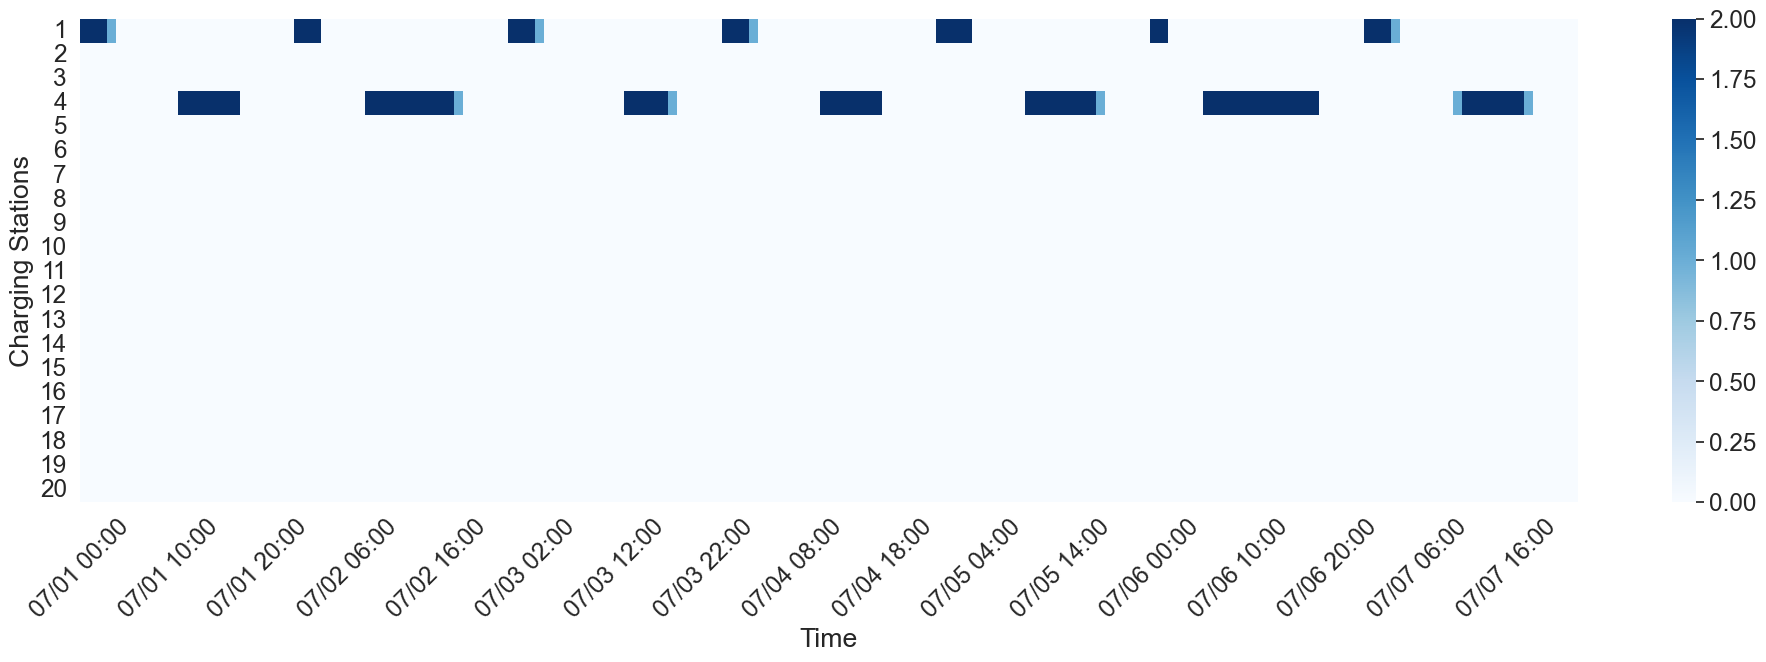

In [114]:
sns.set(rc={'figure.figsize':(20, 7)}, font_scale=1.6)
ax = sns.heatmap(schedule_statistic_count, vmin=0, vmax=2, cmap="Blues")
x_name = list(schedule_statistic_count.columns.strftime('%m/%d %H:00'))
# 設置刻度位置
ax.set_xticks(np.arange(0, len(x_name), 10))
ax.set_xticklabels(x_name[::10])
ax.set_yticklabels([i for i in range(1, 21)])
plt.xticks(np.arange(0, 168, step=10), rotation=45)
plt.yticks(rotation=0)
plt.xlabel("Time")
plt.ylabel("Charging Stations")
plt.tight_layout()
ax

In [115]:
statistic_df = pd.DataFrame([], columns=["locationID", "buildingID", "Total Electricity Cost", "Total Revenue"])

for locationID in schedule_electricity_cost.keys():
    statistic_df.loc[len(statistic_df)] = [locationID, 
                                        location.loc[locationID, "buildingID"],
                                        schedule_electricity_cost[locationID],
                                        schedule_ev_revenue[locationID]]

statistic_df.set_index("locationID", inplace=True)
statistic_df

,buildingID,Total Electricity Cost,Total Revenue
locationID,,,
50230,0,8297.948409,522.0
51199,1,6579.178828,0.0
50841,2,13004.223907,0.0
50692,3,9835.195998,1371.0
51087,4,6223.507574,0.0
51198,5,7023.502976,0.0
50840,6,5849.364571,0.0
50349,7,13966.130481,0.0
50909,8,7288.053933,0.0


### MISP/QLearn Evaluation

In [11]:
import time
path = "Result/Carl/MISP/MISP_Q_Learning_incentive_025_cost_01_sigmoid/SIGMOID_INCENTIVE_UNIT_COST_0.25/2023-07-07/alpha_0.2/"

PATH = "./" + path

columns=[
    "datetime", 
    "date", 
    "userID", 
    "locationID", 
    "buildingID", 
    "chargingLen", 
    "originLocationID", 
    "originChargingHour", 
    "incentive", 
    "score",
]

schedule_df = pd.DataFrame([], columns=columns)
testing_start_time = charging_start_time
null_value = 0

all_request_counts = 0
count = 0

for day in range(7):

    charging_request = get_charging_request(charging_data, testing_start_time)
    all_request_counts += len(charging_request)
    recommend = pd.read_csv(PATH + f"{testing_start_time.strftime('%m%d')}.csv")
    recommend["datetime"] = pd.to_datetime(recommend["datetime"], format="%Y-%m-%d %H:%M:%S")
    
    for request in charging_request:
        try:
            schedule = recommend[recommend["requestID"] == request[0]]
    
            # if schedule["user_accept"].values[0]:
            #     count += 1
            schedule_df.loc[len(schedule_df)] = [
                schedule["datetime"].values[0],
                testing_start_time.strftime("%m%d"),
                schedule["userID"].values[0],
                str(schedule["locationID"].values[0]),
                location.loc[str(schedule["locationID"].values[0]), "buildingID"],
                schedule["chargingLen"].values[0],
                schedule["originLocationID"].values[0],
                schedule["originHour"].values[0],
                schedule["incentive"].values[0],
                schedule["score"].values[0]
        ]
        except Exception as e:
            print(request, e)
            null_value += 1

    testing_start_time += timedelta(days=1)

print(count, all_request_counts, round(count/all_request_counts, 4))
print(null_value)
# schedule_df
schedule_df.to_csv('./temp/MISP_Q_Learning_incentive_025_cost_01_sigmoid_025.csv', index=False)

0 752 0.0
0


In [8]:
import pandas as pd
path = "Result/Carl/MISP/MISP_Q_Learning_incentive_025_cost_01_sigmoid/SIGMOID_INCENTIVE_UNIT_COST_0.15/2023-07-07/alpha_0.2/"

PATH = "./" + path

columns = [
    "datetime", 
    "date", 
    "userID", 
    "locationID", 
    "buildingID", 
    "chargingLen", 
    "originLocationID", 
    "originChargingHour", 
    "incentive", 
    "score",
]

schedule_df = pd.DataFrame([], columns=columns)
testing_start_time = charging_start_time
null_value = 0
# all_request_counts = 0
# count = 0
for day in range(7):

    charging_request = get_charging_request(charging_data, testing_start_time)
    # all_request_counts += len(charging_request)
    recommend = pd.read_csv(PATH + f"{testing_start_time.strftime('%m%d')}.csv")
    recommend["datetime"] = pd.to_datetime(recommend["datetime"], format="%Y-%m-%d %H:%M:%S")
    
    for request in charging_request:
        try:
            schedule = recommend[recommend["requestID"] == request[0]]
            # if schedule["user_accept"].values[0]:
            #     count += 1
            schedule_df.loc[len(schedule_df)] = [
                schedule["datetime"].values[0],
                testing_start_time.strftime("%m%d"),
                schedule["userID"].values[0],
                str(schedule["locationID"].values[0]),
                location.loc[str(schedule["locationID"].values[0]), "buildingID"],
                schedule["chargingLen"].values[0],
                schedule["originLocationID"].values[0],
                schedule["originHour"].values[0],
                schedule["incentive"].values[0],
                schedule["score"].values[0]
        ]
        except Exception as e:
            print(request, e)
            null_value += 1

    testing_start_time += timedelta(days=1)

# print(count, all_request_counts, round(count/all_request_counts, 4))
print(null_value)
# schedule_df.to_csv('MISP_Q_Learning_incentive_025_cost_01_sigmoid_015.csv', index=False)
schedule_df

0


,datetime,date,userID,locationID,buildingID,chargingLen,originLocationID,originChargingHour,incentive,score
0,2018-07-01 12:00:00,0701,606941,50840,6,3.0,51087,17,10,0.815172
1,2018-07-01 16:00:00,0701,604897H,51200,15,1.0,51200,16,0,-1.000000
2,2018-07-01 08:00:00,0701,604760H,50268,19,1.0,50240,17,10,0.611379
3,2018-07-01 12:00:00,0701,V009198,50675,18,2.0,50911,17,10,0.773542
4,2018-07-01 16:00:00,0701,604725H,50261,9,2.0,50261,16,0,-1.000000
...,...,...,...,...,...,...,...,...,...,...
747,2018-07-07 17:00:00,0707,604900H,50266,10,2.0,50266,12,0,-1.000000
748,2018-07-07 13:00:00,0707,604804H,50230,0,2.0,50230,12,0,-1.000000
749,2018-07-07 13:00:00,0707,604745H,51199,1,2.0,51199,12,0,-1.000000
750,2018-07-07 06:00:00,0707,603522H,50230,0,2.0,50911,12,1,0.329815


In [16]:
import time
overage = 0
electricity_price = pd.DataFrame([], columns=["basic_tariff", "current_tariff", "overload_penalty", "total"])
schedule_statistic_count = pd.DataFrame([], columns=[charging_start_time + timedelta(hours=hour) for hour in range(0, 7*24)])

overload_percentage = list()

schedule_revenue = defaultdict()
schedule_ev_charging_volume = list()
schedule_electricity_cost = defaultdict() 
schedule_ev_revenue = defaultdict()

dic = {}
dic_2 = defaultdict(dict)

for cs in location.index:
    
    info = building_data[ (building_data["buildingID"] == location.loc[cs, "buildingID"]) &  (building_data["datetime"] >= building_start_time) & (building_data["datetime"] < building_end_time) ]


    ### EV charging data ###
    ev_info = [0 for i in range(24*7)]
    current = charging_start_time
    for day in range(7):
        for hour in range(24):
            charging_value = len(schedule_df[(schedule_df["locationID"] == cs) &
                                             (schedule_df["datetime"] >= current) &
                                             (schedule_df["datetime"] < (current + timedelta(days=1))) &
                                             (schedule_df["datetime"].dt.hour <= hour) &
                                             ((schedule_df['datetime'].dt.hour + schedule_df["chargingLen"]) > hour)]) * charging_speed
            ev_info[(day * 24) + hour] = charging_value
        current += timedelta(days=1)

    schedule_ev_charging_volume.append(ev_info)
    schedule_ev_revenue[cs] = sum(ev_info) * charging_fee
    info["charging"] = ev_info
    info["total"] = info["consumption"] - info["generation"] + info["charging"]

    ### check number of exceed ###
    info["exceed"] = info["total"] - location.loc[cs, "contractCapacity"]
    info["exceed"] = info["exceed"].apply(lambda x: 0 if x < 0 else x)

    overload_slots = 0
    for raw in info["exceed"]:
        if raw != 0:
            overload_slots += 1
        # overload_slots += math.ceil(raw / charging_speed)

    overload_percentage.append(overload_slots / (7 * 24))
    # print(int(location.loc[cs, 'buildingID']), ":")
    # print(f"overload = {'{:.2f}'.format(info['exceed'].sum())}")
    # print(f"overload_percentage = {'{:.4f}'.format(overload_percentage[-1])}")

    info_output = info.applymap(lambda x: x.strftime('%Y-%m-%d %H:%M:%S') if isinstance(x, pd.Timestamp) else x)
    dic[cs] = info_output.to_dict(orient='records')
    overage += info["exceed"].sum()
    basic_tariff, current_tariff, overload_penalty = calculate_electricity_price(location, cs, info)
    total_price = basic_tariff + current_tariff + overload_penalty
    electricity_price.loc[len(electricity_price)] = [basic_tariff, current_tariff, overload_penalty, total_price]
    schedule_revenue[cs] = (-1) * total_price + (charging_fee * info["charging"].sum())

    dic_2[cs]["basic_tariff"] = basic_tariff
    dic_2[cs]["current_tariff"] = current_tariff
    dic_2[cs]["overload_penalty"] = overload_penalty
    dic_2[cs]["total_price"] = total_price
    dic_2[cs]["schedule_revenue"] = schedule_revenue[cs]

    schedule_electricity_cost[cs] = total_price
    # print(f"revenue = {'{:.2f}'.format(schedule_revenue[cs])}")

    info["chargingCount"] = info["charging"].apply(lambda x: x/charging_speed)
    info.set_index("datetime", inplace=True)
    schedule_statistic_count.loc[len(schedule_statistic_count)] = info["chargingCount"].T

import json
# print(dic)
with open('./temp/MISP_Q_Learning_incentive_025_cost_01_sigmoid_025_all_cost.json', 'w') as f:
    json.dump(dic_2, f)
print("==========================")
print(f"average revenue = {float(sum(schedule_revenue.values()) / 20)}")
print(electricity_price.mean(axis=0))

average revenue = -8313.558252153558
basic_tariff        3924.817141
current_tariff      3771.399029
overload_penalty     820.892082
total               8517.108252
dtype: float64


In [9]:
total_incentive = schedule_df['incentive'].sum()
total_incentive/20

126.45

In [10]:
overage = 0
electricity_price = pd.DataFrame([], columns=["basic_tariff", "current_tariff", "overload_penalty", "total"])
schedule_statistic_count = pd.DataFrame([], columns=[charging_start_time + timedelta(hours=hour) for hour in range(0, 7*24)])

overload_percentage = list()

schedule_revenue = defaultdict()
schedule_ev_charging_volume = list()
schedule_electricity_cost = defaultdict() 
schedule_ev_revenue = defaultdict()

for cs in location.index:
    
    info = building_data[ (building_data["buildingID"] == location.loc[cs, "buildingID"]) &  (building_data["datetime"] >= building_start_time) & (building_data["datetime"] < building_end_time) ]

    ### EV charging data ###
    ev_info = [0 for i in range(24*7)]
    current = charging_start_time
    for day in range(7):
        for hour in range(24):
            charging_value = len(schedule_df[(schedule_df["locationID"] == cs) &
                                             (schedule_df["datetime"] >= current) &
                                             (schedule_df["datetime"] < (current + timedelta(days=1))) &
                                             (schedule_df["datetime"].dt.hour <= hour) &
                                             ((schedule_df['datetime'].dt.hour + schedule_df["chargingLen"]) > hour)]) * charging_speed
            ev_info[(day * 24) + hour] = charging_value
        current += timedelta(days=1)

    schedule_ev_charging_volume.append(ev_info)
    schedule_ev_revenue[cs] = sum(ev_info) * charging_fee
    info["charging"] = ev_info
    info["total"] = info["consumption"] - info["generation"] + info["charging"]

    ### check number of exceed ###
    info["exceed"] = info["total"] - location.loc[cs, "contractCapacity"]
    info["exceed"] = info["exceed"].apply(lambda x: 0 if x < 0 else x)

    overload_slots = 0
    for raw in info["exceed"]:
        if raw != 0:
            overload_slots += 1
        # overload_slots += math.ceil(raw / charging_speed)

    overload_percentage.append(overload_slots / (7 * 24))
    # print(int(location.loc[cs, 'buildingID']), ":")
    # print(f"overload = {'{:.2f}'.format(info['exceed'].sum())}")
    # print(f"overload_percentage = {'{:.4f}'.format(overload_percentage[-1])}")
    
    overage += info["exceed"].sum()
    basic_tariff, current_tariff, overload_penalty = calculate_electricity_price(location, cs, info)
    total_price = basic_tariff + current_tariff + overload_penalty
    electricity_price.loc[len(electricity_price)] = [basic_tariff, current_tariff, overload_penalty, total_price]
    schedule_revenue[cs] = (-1) * total_price + (charging_fee * info["charging"].sum())
    schedule_electricity_cost[cs] = total_price
    # print(f"revenue = {'{:.2f}'.format(schedule_revenue[cs])}")

    info["chargingCount"] = info["charging"].apply(lambda x: x/charging_speed)
    info.set_index("datetime", inplace=True)
    schedule_statistic_count.loc[len(schedule_statistic_count)] = info["chargingCount"].T

print("==========================")
print(f"average revenue = {float(sum(schedule_revenue.values()) / 20)}")
print(electricity_price.mean(axis=0))

average revenue = -8010.776871405009
basic_tariff        3924.817141
current_tariff      3750.357029
overload_penalty     539.152701
total               8214.326871
dtype: float64


## variation 1

In [281]:
import numpy as np

testing_start_time = charging_start_time
schedule_utilization = defaultdict(list)
schedule_var = list()
while testing_start_time < charging_end_time:
    for cs in range(20):
        truth_slots = truth_data.loc[(truth_data["datetime"] == testing_start_time) & (truth_data["buildingID"] == str(cs)), "parkingSlots"].values[0]
        
        days = (testing_start_time - charging_start_time).days
        seconds = (testing_start_time - charging_start_time).seconds
        schedule_slots = schedule_ev_charging_volume[cs][int(days * 24 + (seconds / 3600))] / charging_speed
        schedule_utilization[testing_start_time].append(schedule_slots / truth_slots if truth_slots != 0 else 1)
        

    schedule_var.append(np.var(schedule_utilization[testing_start_time]))
    testing_start_time += timedelta(hours=1)

schedule_variation = sum(schedule_var) / len(schedule_var)
round(schedule_variation, 4)

0.1152

## Variaiton 2

In [282]:
 # 遍歷每個時間點
data = schedule_utilization

# 初始化一個字典來存儲每個小時的利用率總和，以及一個數量計數器
total_usage = defaultdict(list)

# 遍历所有的时间点
for dt, usage in data.items():
    # 检查这个时间点是否在我们所需的七天范围内
    for i in range(20):
        total_usage[i].append(usage[i])

# 计算每个小时的平均利用率

value_sum = 0
for value in total_usage.values():
    value_sum += np.var(value)

round(value_sum/20, 4)

0.1384

## Spatial Variation

In [240]:
from datetime import timedelta

# 假設你的資料叫做 data
data = schedule_utilization

# 初始化一個列表來儲存每個充電站的總利用率
total_usage = [0.0]*20

# 初始化一個計數器來計算時間點的數量
count = 0

# 遍歷每個時間點
for dt, usage in data.items():
    # 將該時間點的每個充電站的利用率加到總利用率中
    for i in range(20):
        total_usage[i] += usage[i]
    # 增加時間點的計數器
    count += 1

# 計算每個充電站的平均利用率
average_usage = [usage / count for usage in total_usage]

round(np.var(average_usage), 4)

0.0167

## Temporal variation 1

In [37]:
from collections import defaultdict
from datetime import datetime

# 假設你的資料叫做 data
data = schedule_utilization

# 初始化一個字典來存儲每個小時的利用率總和，以及一個數量計數器
total_usage = list()

# 遍历所有的时间点
for dt, usage in data.items():

    total_usage.append(sum(usage)/20)


round(np.var(total_usage), 4)

0.051

## Temporal Variation 2 

In [38]:
from collections import defaultdict
from datetime import datetime

# 假設你的資料叫做 data
data = schedule_utilization

# 初始化一個字典來存儲每個小時的利用率總和，以及一個數量計數器
total_usage_by_hour = defaultdict(float)
counts_by_hour = defaultdict(int)

# 遍历所有的时间点
for dt, usage in data.items():
    # 检查这个时间点是否在我们所需的七天范围内
    hour_key = dt.hour  # 创建一个关键字来表示小时
    total_usage_by_hour[hour_key] += (sum(usage)/20)
    counts_by_hour[hour_key] += 1

# 计算每个小时的平均利用率
average_usage_by_hour =[total_usage / counts_by_hour[hour] for hour, total_usage in total_usage_by_hour.items()]
average_usage_by_hour

round(np.var(average_usage_by_hour), 4)



0.0413

In [283]:
user_list = get_user_list(parser.parse("2018-07-01"))
history_charging_df = charging_data[charging_data["createdNew"] < parser.parse("2018-07-01")].copy()
history_charging_df["facilityType"] = history_charging_df["locationId"].apply(lambda x: location.loc[str(x), "FacilityType"])
history_charging_df["createdHour"] = history_charging_df["createdHour"].astype(int)

history_user_group = history_charging_df.groupby(["userId"])
user_preference = defaultdict(dict)

for user in user_list:
    ## 充電站選多個
    user_preference[user]["locationId"] = list()
    user_preference[user]["facilityType"] = list()
    user_preference[user]["createdHour"] = list()

    most_prefer_num = math.floor(len(history_user_group.get_group(user)) / 2)
    cs_charging_num = history_user_group.get_group(user).groupby("locationId").size()
    for cs in cs_charging_num.keys():
        if cs_charging_num[cs] >= most_prefer_num:
            user_preference[user]["locationId"].append(cs)
            user_preference[user]["facilityType"].append(location.loc[cs, "FacilityType"])
            user_preference[user]["createdHour"] += list(history_user_group.get_group(user).groupby("locationId").get_group(cs).groupby("createdHour").size().keys())
            user_preference[user]["createdHour"] = sorted(list(set(user_preference[user]["createdHour"])))
    ### 避免有人都沒有超過 50% 的
    if len(user_preference[user]["locationId"]) == 0:
        user_preference[user]["locationId"].append(cs_charging_num.sort_values(ascending=False).keys()[0])
        user_preference[user]["facilityType"].append(location.loc[user_preference[user]["locationId"][0], "FacilityType"])
        user_preference[user]["createdHour"] += list(history_user_group.get_group(user).groupby("locationId").get_group(user_preference[user]["locationId"][0]).groupby("createdHour").size().keys())
        user_preference[user]["createdHour"] = sorted(list(set(user_preference[user]["createdHour"])))

 
    ## 時間以選中的充電站為主
    # user_preference[user]["locationId"] = history_user_group.get_group(user).groupby("locationId").size().sort_values(ascending=False).keys()[0]
    # user_preference[user]["facilityType"] = int(location.loc[user_preference[user]["locationId"], "FacilityType"])
    # user_preference[user]["createdHour"] = history_user_group.get_group(user).groupby("locationId").get_group(user_preference[user]["locationId"]).groupby("createdHour").size().sort_values(ascending=False).keys()[0]

    ## 時間以最多次的為主
    # user_preference[user]["facilityType"] = history_user_group.get_group(user).groupby("facilityType").size().sort_values(ascending=False).keys()[0]
    # user_preference[user]["createdHour"] = history_user_group.get_group(user).groupby("createdHour").size().sort_values(ascending=False).keys()[0]
    # user_preference[user]["locationId"] = history_user_group.get_group(user).groupby("locationId").size().sort_values(ascending=False).keys()[0]



In [285]:
unfavored_type = 0
hit_type = 0
distance = 0
time = 0

for idx, raw in schedule_df.iterrows():
    
    if raw["userID"] == '603475':
        continue
    if location.loc[raw["locationID"], "FacilityType"] in user_preference[raw["userID"]]["facilityType"]:
        hit_type += 1
    if not location.loc[raw["locationID"], "FacilityType"] in user_preference[raw["userID"]]["facilityType"]:
        unfavored_type += 1
    
    min_distance = 1000
    for cs in user_preference[raw["userID"]]["locationId"]:
        value = haversine(location.loc[raw["locationID"], ["Latitude", "Longitude"]].values, location.loc[cs, ["Latitude", "Longitude"]].values, unit = Unit.KILOMETERS)
        min_distance = min(min_distance, value)
    distance += min_distance

    min_time = 1000
    for hour in user_preference[raw["userID"]]["createdHour"]:
        value = abs(raw["datetime"].hour - hour)
        min_time = min(min_time, value)
    time += min_time
    
print(f"average hit type: {round(hit_type / len(schedule_df), 4)}")
print(f"average unfavored type: {round(unfavored_type / len(schedule_df), 4)}")
print(f"average distance: {round(distance / len(schedule_df), 4)}")
print(f"average time: {round(time / len(schedule_df), 4)}")

average hit type: 0.6723
average unfavored type: 0.3277
average distance: 2.6429
average time: 1.098


In [287]:
import json
with open('user_facility_perc_dic.json', 'r') as f:
    # Load JSON data from file
    user_facility_perc_dic = json.load(f)


user_list = get_user_list(parser.parse("2018-07-01"))
history_charging_df = charging_data[charging_data["createdNew"] < parser.parse("2018-07-01")].copy()
history_charging_df["facilityType"] = history_charging_df["locationId"].apply(lambda x: location.loc[str(x), "FacilityType"])
history_charging_df["createdHour"] = history_charging_df["createdHour"].astype(int)

history_user_group = history_charging_df.groupby(["userId"])


hit_type = 0
unfavored_type = 0
distance = 0
time = 0

for idx, raw in schedule_df.iterrows():
    
    facility_type_list = [int(i) for i in user_facility_perc_dic[raw["userID"]].keys()]
    facility_type = location.loc[raw["locationID"], "FacilityType"]
    if facility_type in facility_type_list and user_facility_perc_dic[raw["userID"]][str(facility_type)] >= 0.4:
        hit_type += 1
    if facility_type in facility_type_list and user_facility_perc_dic[raw["userID"]][str(facility_type)] < 0.4:
        unfavored_type += 1
    if facility_type not in facility_type_list:
        unfavored_type += 1
    
    min_distance = 1000
    count = 0
    try:
        for cs in user_preference[raw["userID"]]["locationId"]:
            value = haversine(location.loc[raw["locationID"], ["Latitude", "Longitude"]].values, location.loc[cs, ["Latitude", "Longitude"]].values, unit = Unit.KILOMETERS)
            min_distance = min(min_distance, value)
        distance += min_distance

        min_time = 1000
        for hour in user_preference[raw["userID"]]["createdHour"]:
            value = abs(raw["datetime"].hour - hour)
            min_time = min(min_time, value)
        time += min_time
    except Exception as e:
        count += 1
        print(count)
        print(cs)
        print(e)


print(f"hit type: {hit_type}")
print(f"average hit type: {round(hit_type / len(schedule_df), 4)}")
print(f"unfavored type: {unfavored_type}")
print(f"average unfavored type: {round(unfavored_type / len(schedule_df), 4)}")
print(f"average distance: {round(distance / len(schedule_df), 4)}")
print(f"average time: {round(time / len(schedule_df), 4)}")

    

hit type: 390
average hit type: 0.6588
unfavored type: 202
average unfavored type: 0.3412
average distance: 2.6429
average time: 1.098


In [289]:
import json
with open('user_facility_perc_dic.json', 'r') as f:
    # Load JSON data from file
    user_facility_perc_dic = json.load(f)

user_list = get_user_list(parser.parse("2018-07-01"))
history_charging_df = charging_data[charging_data["createdNew"] < parser.parse("2018-07-01")].copy()
history_charging_df["facilityType"] = history_charging_df["locationId"].apply(lambda x: location.loc[str(x), "FacilityType"])
history_charging_df["createdHour"] = history_charging_df["createdHour"].astype(int)

history_user_group = history_charging_df.groupby(["userId"])


hit_type = 0
unfavored_type = 0
distance = 0
time = 0

for idx, raw in schedule_df.iterrows():
    
    facility_type_list = [int(i) for i in user_facility_perc_dic[raw["userID"]].keys()]
    facility_type = location.loc[raw["locationID"], "FacilityType"]
    if facility_type in facility_type_list and user_facility_perc_dic[raw["userID"]][str(facility_type)] >= 0.3:
        hit_type += 1
    if facility_type in facility_type_list and user_facility_perc_dic[raw["userID"]][str(facility_type)] < 0.3:
        unfavored_type += 1
    if facility_type not in facility_type_list:
        unfavored_type += 1
    
    min_distance = 1000
    count = 0
    try:
        for cs in user_preference[raw["userID"]]["locationId"]:
            value = haversine(location.loc[raw["locationID"], ["Latitude", "Longitude"]].values, location.loc[cs, ["Latitude", "Longitude"]].values, unit = Unit.KILOMETERS)
            min_distance = min(min_distance, value)
        distance += min_distance

        min_time = 1000
        for hour in user_preference[raw["userID"]]["createdHour"]:
            value = abs(raw["datetime"].hour - hour)
            min_time = min(min_time, value)
        time += min_time
    except Exception as e:
        count += 1
        print(count)
        print(cs)
        print(e)


print(f"hit type: {hit_type}")
print(f"average hit type: {round(hit_type / len(schedule_df), 4)}")
print(f"unfavored type: {unfavored_type}")
print(f"average unfavored type: {round(unfavored_type / len(schedule_df), 4)}")
print(f"average distance: {round(distance / len(schedule_df), 4)}")
print(f"average time: {round(time / len(schedule_df), 4)}")

    

hit type: 400
average hit type: 0.6757
unfavored type: 192
average unfavored type: 0.3243
average distance: 2.6429
average time: 1.098


In [290]:
'''
使用奐揚的 user preference, unfavored 0.4
'''
with open('user_facility_perc_dic.json', 'r') as f:
    # Load JSON data from file
    user_facility_perc_dic = json.load(f)


favor_count = []

for idx, raw in schedule_df.iterrows():
    
    facility_type_list = [int(i) for i in user_facility_perc_dic[raw["userID"]].keys()]
    facility_type = location.loc[raw["locationID"], "FacilityType"]
    if facility_type in facility_type_list:
        favor_count.append(user_facility_perc_dic[raw["userID"]][str(facility_type)])
    else:
        favor_count.append(0)

print(f"favor ratio: {round(sum(favor_count)/len(favor_count), 4)}")

favor ratio: 0.5845
